In [3]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import time

//anaconda/envs/python3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #3
**Harvard University**<br>
**Spring 2017**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Thursday, Febrary 16th, 2017 at 11:59pm

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Problem 1: Optimization via Descent

Suppose you are building a pricing model for laying down telecom cables over a geographical region. Your model takes as input a pair of  coordinates, $(x, y)$, and contains two parameters, $\lambda_1, \lambda_2$. Given a coordinate, $(x, y)$, and model parameters, the loss in revenue corresponding to the price model at location $(x, y)$ is described by
$$
L(x, y, \lambda_1, \lambda_2) = 0.000045\lambda_2^2 y - 0.000098\lambda_1^2 x + 0.003926\lambda_1 x\exp\left\{\left(y^2 - x^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}
$$
Read the data contained in `HW3_data.csv`. This is a set of coordinates configured on the curve $y^2 - x^2 = -0.1$. Given the data, find parameters $\lambda_1, \lambda_2$ that minimize the net loss over the entire dataset.

## Read the data

In [4]:
telecom_data = pd.read_csv('./HW3_data.csv', header=None)
telecom_data = np.array(telecom_data).T
X = telecom_data[:,0]
Y = telecom_data[:,1]

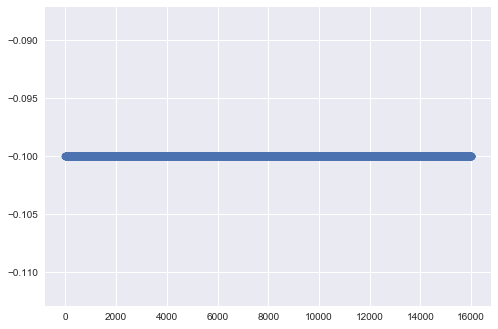

In [5]:
# check it has been read in correctly
a = Y**2 - X**2
plt.scatter(np.arange(a.shape[0]),a)

## Define helper functions

In [6]:
p = 0.000045
q = 0.000098
r = 0.003926

def exp_fn(X, Y, lmd1, lmd2):
    return r*X*np.exp((Y**2 - X**2)*(lmd1**2 + lmd2**2))

def f(X, Y, lmd1, lmd2):
    fs = p*(lmd2**2)*Y - q*(lmd2**2)*X + lmd1*exp_fn(X, Y, lmd1, lmd2)
    return np.sum(fs)

def fprime_lmd1(X, Y, lmd1, lmd2):
    fp = -2*q*lmd1*X + (1 + 2*(lmd1**2)*(Y**2 - X**2))*exp_fn(X, Y, lmd1, lmd2)
    return np.sum(fp)

def fprime_lmd2(X, Y, lmd1, lmd2):
    fp = 2*p*lmd2*Y + 2*lmd1*lmd2*(Y**2 - X**2)*exp_fn(X, Y, lmd1, lmd2)
    return np.sum(fp)

In [7]:
# check if derivatives are 0 at the optimum values of lambda
print(fprime_lmd1(X, Y, 2.05384, 0))
print(fprime_lmd2(X, Y, 2.05384, 0))

-4.53208924679e-05
0.0


In [77]:
def gradient_descent(X, Y, lmd_init, stopping_condition, step=0.001, maxsteps=0, precision = 0.001):
    
    costs = []
    m = Y.size # number of data points
    
    lmd = lmd_init
    
    history = [] # to store all thetas
    
    counter = 0
    oldcost = 0
    
    currentcost = f(X, Y, *(lmd))
    
    costs.append(currentcost)
    history.append(lmd)
    counter+=1
    
    update_times = []
    
#     while np.linalg.norm(np.array(*(lmd)) - np.array([2.05384, 0])) > precision:
    while stopping_condition(currentcost, oldcost, lmd, precision):
        start = time.time()
        oldcost=currentcost
        gradient = np.array([fprime_lmd1(X,Y,*(lmd)), fprime_lmd2(X,Y,*(lmd))])
        lmd = lmd - step*gradient # update
        
        end = time.time()
        update_times.append(end-start)
        
        
        history.append(lmd)
        currentcost = f(X, Y, *(lmd))
        costs.append(currentcost)
        counter+=1
        if maxsteps:
            if counter == maxsteps:
                break
    return history, costs, counter, lmd, update_times

In [95]:
# find the gradient one point at a time 

def sgd(X, Y, lmd_init, stopping_condition, step=0.001, maxsteps=0, precision=0.001, cost=False):
    m = Y.size 
    
    # shuffle data
    neworder = np.random.permutation(m)      
    X = X[neworder]
    Y = Y[neworder]
            
    # save history 
    history = [] 
    history_costs = []
    update_times = []
    
    # initialise params
    oldlmd = 0
    lmd = lmd_init
    counter = 0
    epoch = 0 
    
    # update history 
    history.append(lmd)
    
    # index of data point
    i = 0 

    # save the costs 
    if cost:
        currentcost = f(X[i],Y[i], *(lmd))
        counter+=1
        costsum = currentcost
        history_costs.append(costsum/counter)
    
    # iterate through all data points 
    while stopping_condition(lmd, precision):
        
        start = time.time()
        
        # update gradient 
        gradient = np.array([fprime_lmd1(X[i],Y[i],*(lmd)), fprime_lmd2(X[i],Y[i],*(lmd))])
        oldlmd = lmd
        # update lambda
        lmd = lmd - step * gradient
        
        end = time.time()
        
        update_times.append(end-start)
        
        # increment observation index
        i += 1
        
        # reached one past the end of the data 
        if i == m:
            #break
            epoch +=1
            
            # shuffle the data
            neworder = np.random.permutation(m)
            X = X[neworder]
            Y = Y[neworder]
            
            # reset index to 0 
            i = 0
     
        # save the costs 
        if cost:
            currentcost = f(X[i],Y[i], *(lmd))
            costsum += currentcost
            history_costs.append(costsum/counter)
        
        counter +=1
        history.append(lmd)
        
        if maxsteps:
            if counter == maxsteps:
                break
                
                
    return history, counter, epoch, history_costs, lmd, update_times

### Part A
- Visually verify that for $\lambda_1 = 2.05384, \lambda_2 = 0$, the loss function $L$ is minimized for the given data.
- Implement gradient descent for minimizing $L$ for the given data, using the learning rate of 0.001.
- Implement stochastic gradient descent for minimizing $L$ for the given data, using the learning rate of 0.001.


### Plot the loss function as a function of $\lambda 1$ and $\lambda 2$

In [192]:
l1 = 2.05384
l2 = 0
m = Y.shape
# range of l1 and l2
lm1 = np.linspace(l1 - 10 , l1 + 10, 100)
lm2 = np.linspace(l2 - 10, l2 + 10, 100)

def plot_cost():
    # optimum values
    LM1, LM2 = np.meshgrid(lm1, lm2)

    l = np.array([f(X,Y, *(lmd))
                   for lmd in zip(np.ravel(LM1), np.ravel(LM2))])
    L = l.reshape(LM1.shape)

    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(LM1, LM2, L, rstride=1, cstride=1, color='b', alpha=0.2)
    ax.contour(LM1, LM2, L, 20, color='b', alpha=0.5, offset=f(X, Y, l1, l2), stride=50)

    ax.set_xlabel('$\lambda1$')
    ax.set_ylabel('$\lambda2$')
    ax.set_zlabel('Total cost $L(x,y,\lambda1,\lambda2)$')
    ax.view_init(elev=30., azim=30)

    # plot the optimum 
    ax.plot([l1],[l2], f(X, Y, l1, l2) , markerfacecolor='r', markeredgecolor='r', marker='o', markersize=7);
    return ax

Best Cost:  -10.776501027


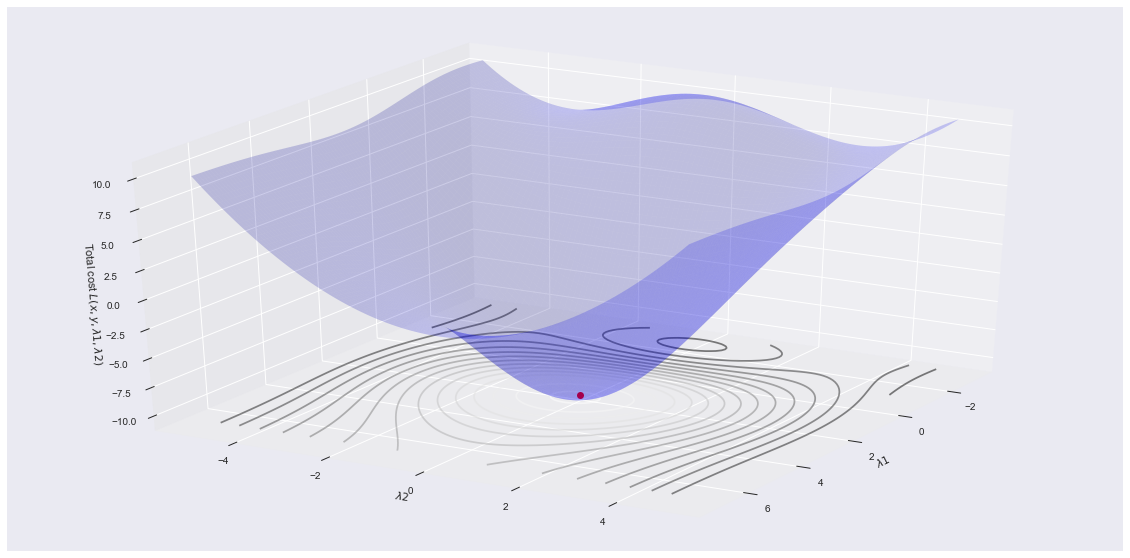

In [11]:
ax1 = plot_cost()
print('Best Cost: ',  f(X, Y, l1, l2))

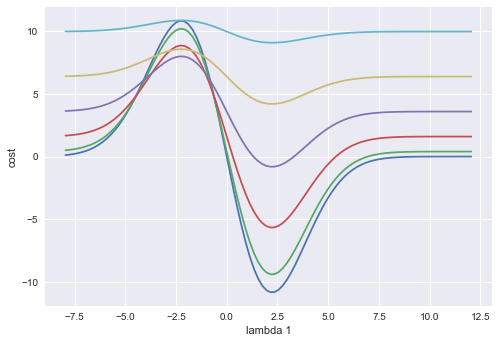

In [198]:
plt.plot(lm1,np.array([[f(X,Y,l1,l2) for l1 in lm1] for l2 in np.arange(0,6)]).T); 
plt.xlabel('lambda 1')
plt.ylabel('cost')

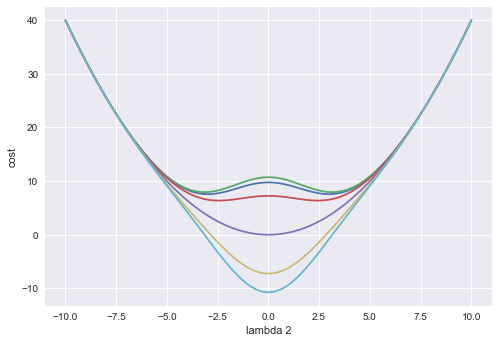

In [199]:
plt.plot(lm2,np.array([[f(X,Y,l1,l2) for l2 in lm2] for l1 in np.arange(-3,3)]).T);
plt.xlabel('lambda 2')
plt.ylabel('cost')

Visually it is possible to see that the optimum value of $\lambda 1$ and $\lambda 2$ results in a loss which is at the global minimum of the loss function. 

### Define the stopping condition to check difference in cost on each iteration

In [74]:
def stopping_condition(currentcost, oldcost, lmd, precision):
    return abs(currentcost - oldcost) > precision

### Gradient descent using the learning rate of 0.001

In [78]:
lmd_init = [1, 1] + np.random.rand(2)
history_gd, cost_gd, counter_gd, lmd_gd, update_times = gradient_descent(X, Y, lmd_init, stopping_condition=stopping_condition, step=0.001, maxsteps=5000)

In [79]:
print('optimum lambdas ', lmd_gd)

optimum lambdas  [ 2.0252983   0.34254837]


(array([-11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.]),
 <a list of 8 Text yticklabel objects>)

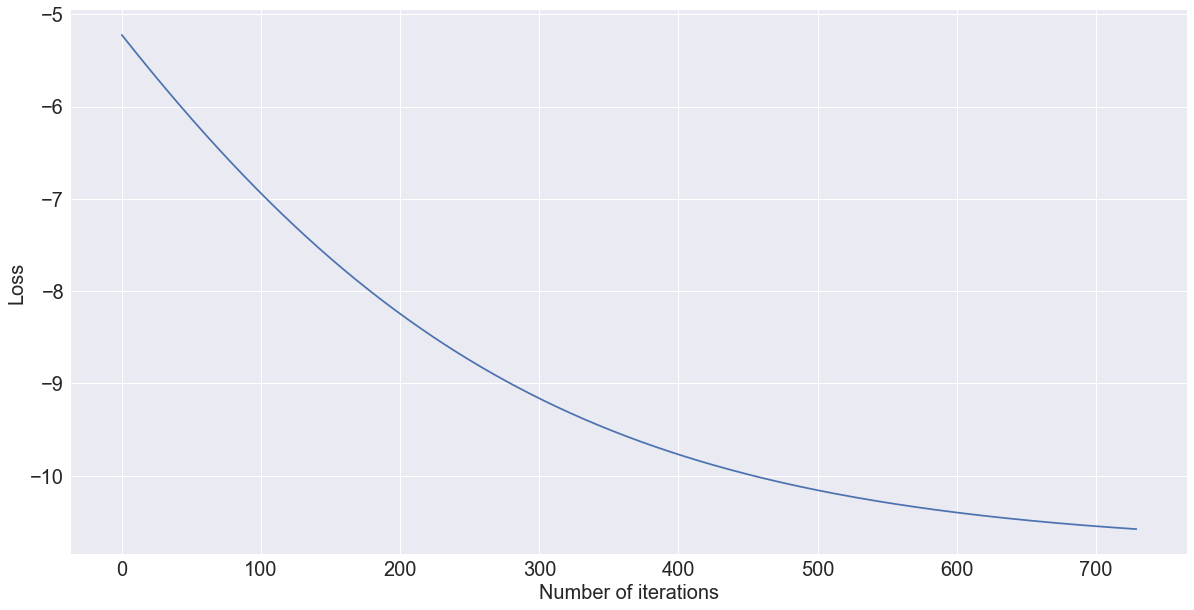

In [80]:
plt.figure(figsize=(20, 10))
plt.plot(range(len(cost_gd)), cost_gd)
plt.xlabel('Number of iterations', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

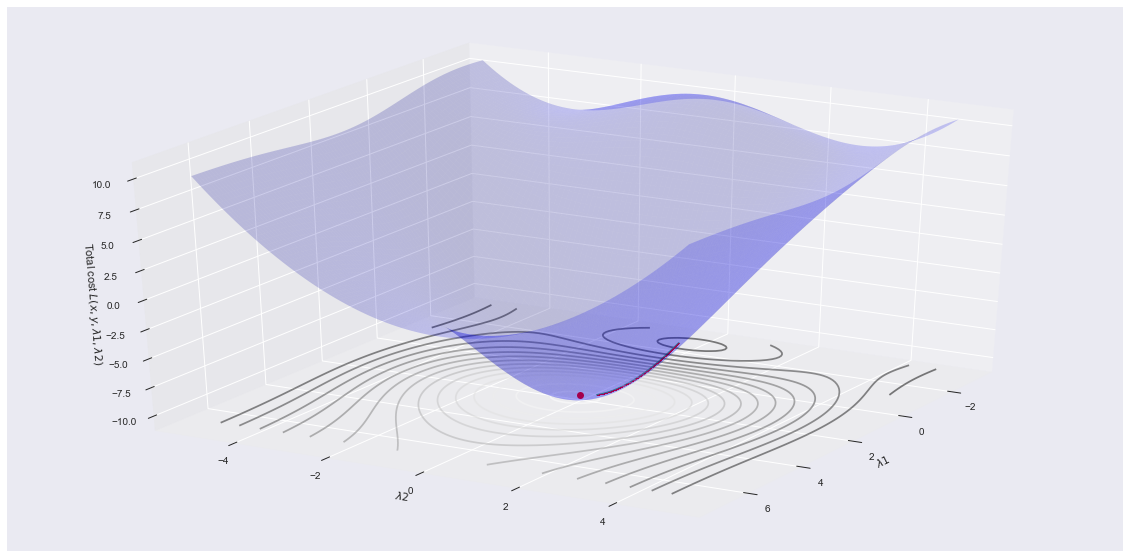

In [20]:
ax1 = plot_cost()
ax1.plot([t[0] for t in history_gd], [t[1] for t in history_gd], cost_gd , markerfacecolor='r', markeredgecolor='r', marker='.', markersize=2);

From the 3D plot of the cost as a function of the hyperparameters it is clear that gradient descent updates the values of lambdas such that the cost moves towards the minimum point. 

The precision is measured relative to the difference in cost between iterations - if the precision is increased the values of lambda converge to the global optimum. 

In [23]:
lmd_init = [1, 1] + np.random.rand(2)
history_gd, cost_gd, counter_gd, lmd_gd, update_times = gradient_descent(X, Y, lmd_init, step=0.001, maxsteps=5000, precision=0.0000001)

In [24]:
print('optimum lambdas ', lmd_gd)

optimum lambdas  [ 2.05384549  0.00337105]


### Stochastic gradient descent using a learning rate of 0.001

In [96]:
# no stopping condition needed 
def stopping_condition_sgd(lmd, precision):
    return 1

In [97]:
lmd_init = [1, 1] + np.random.rand(2)
history_sgd, counter_sgd, epoch_sgd, costs_sgd, lmd_sgd, update_times_sgd = sgd(X, Y, lmd_init, stopping_condition=stopping_condition_sgd, step=0.001, maxsteps=5000, cost=True)

In [98]:
print('starting lambda ', lmd_init)
print('final lambda ', lmd_sgd)

starting lambda  [ 1.33715997  1.85917935]
final lambda  [ 1.3449645   1.85225606]


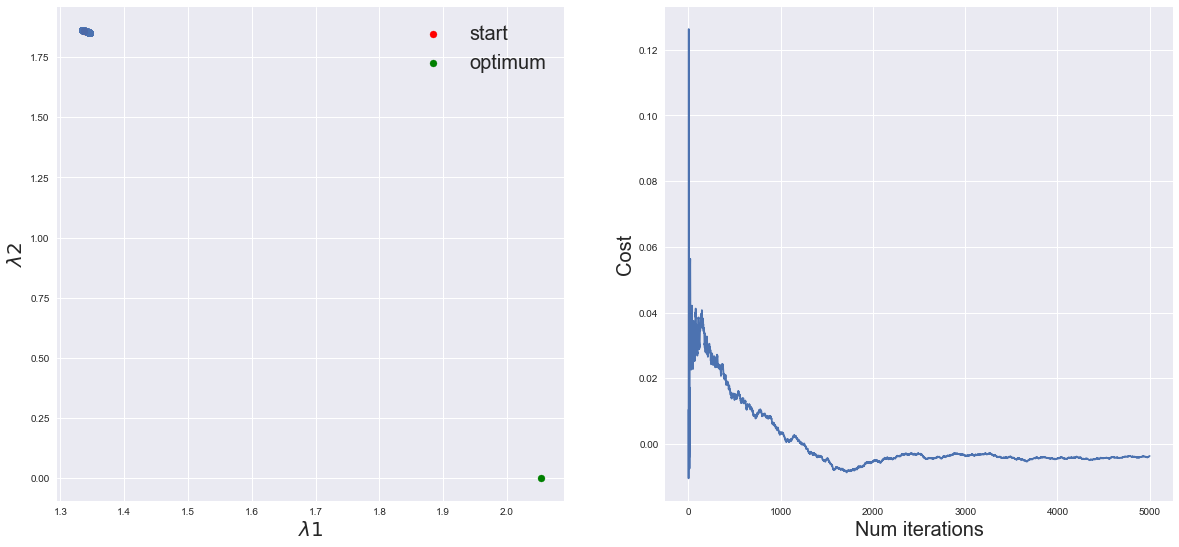

In [99]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.scatter(lmd_init[0],lmd_init[1], color='r', label='start')
plt.scatter(2.053, 0, color='g', label='optimum')
plt.xlabel('$\lambda 1$', fontsize=20)
plt.ylabel('$\lambda 2$', fontsize=20)
plt.plot([i[0] for i in history_sgd],[i[1] for i in history_sgd],'o-', alpha=0.1)
plt.legend(fontsize=20)

plt.subplot(222)
plt.plot(range(len(costs_sgd)), costs_sgd)
plt.xlabel('Num iterations', fontsize=20)
plt.ylabel('Cost', fontsize=20)

With a step size of 0.001, and a max number of steps of 5000, stochastic gradient descent is not converging to the optimum solution for the lamdas. To improve performance, the step size and/or max number of iterations can be increased. 

Increasing the step size to 0.7 resulted in better convergence. 

In [102]:
lmd_init = [1, 1] + np.random.rand(2)
history_sgd, counter_sgd, epoch_sgd, costs_sgd, lmd_sgd, update_times_sgd = sgd(X, Y, lmd_init, stopping_condition = stopping_condition_sgd, step=0.7, maxsteps=7000, cost=True)

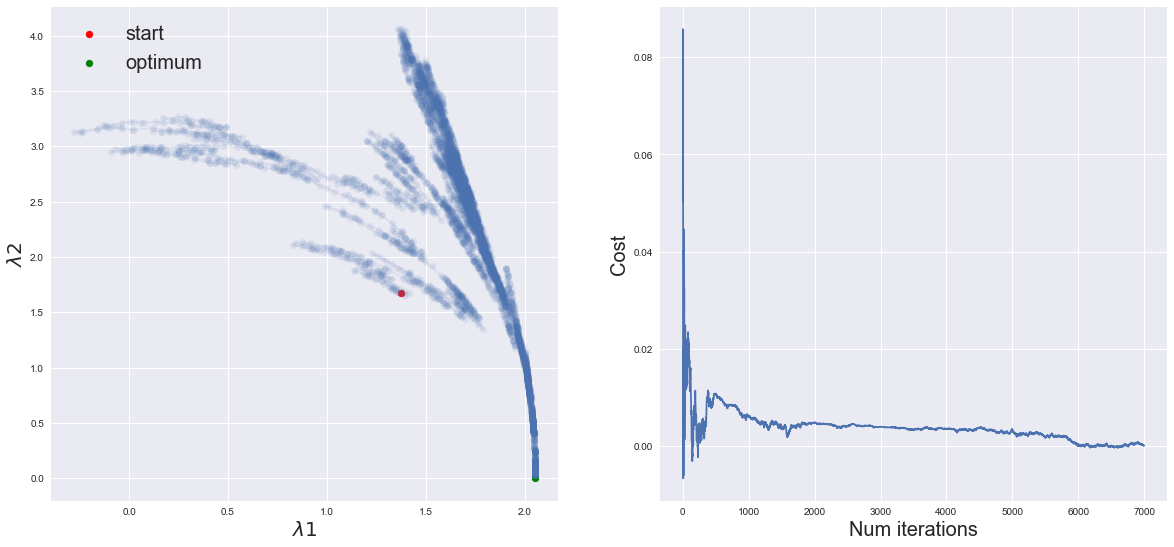

In [103]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.scatter(lmd_init[0],lmd_init[1], color='r', label='start')
plt.scatter(2.053, 0, color='g', label='optimum')
plt.xlabel('$\lambda 1$', fontsize=20)
plt.ylabel('$\lambda 2$', fontsize=20)
plt.plot([i[0] for i in history_sgd],[i[1] for i in history_sgd],'o-', alpha=0.1)
plt.legend(loc='best', fontsize=20)

plt.subplot(222)
plt.plot(range(len(costs_sgd)), costs_sgd)
plt.xlabel('Num iterations', fontsize=20)
plt.ylabel('Cost', fontsize=20)

### Part B
- Compare the average time it takes to update the parameter estimation in each iteration of the two implementations. Which method is faster? Briefly explain why this result should be expected.
- Compare the number of iterations it takes for each algorithm to obtain an estimate accurate to `1e-3` (you may wish to set a cap for maximum number of iterations). Which method converges to the optimal point in fewer iterations? Briefly explain why this result should be expected.


In [104]:
# average time for update of parameter estimation in gradient descent
lmd_init = [1, 1] + np.random.rand(2)
history_gd, cost_gd, counter_gd, lmd_gd, update_times = gradient_descent(X, Y, 
                                                                         lmd_init, 
                                                                         stopping_condition = stopping_condition, 
                                                                         step=0.001, 
                                                                         maxsteps=5000)
print('GD: Average parameter update time', np.mean(update_times))

# average time for update of parameter estimation  in stochastic gradient descent  
history_sgd, counter_sgd, epoch_sgd, costs_sgd, lmd_sgd, update_times_sgd = sgd(X, Y, 
                                                                                lmd_init, 
                                                                                stopping_condition=stopping_condition_sgd, 
                                                                                step=0.7, 
                                                                                maxsteps=7000, 
                                                                                cost=True)
print('SGD: Average parameter update time', np.mean(update_times_sgd))

GD: Average parameter update time 0.00073159780064
GD: Average parameter update time 3.03607103501e-05


In [155]:
def stopping_condition_precision_gd(currentcost, oldcost, lmd, precision):
    return np.linalg.norm(np.array([lmd[0], lmd[1]]) - np.array([2.05384, 0])) > 1e-3

def stopping_condition_precision_sgd(lmd, precision):
    return np.linalg.norm(np.array([lmd[0], lmd[1]]) - np.array([2.05384, 0])) > 1e-3

In [200]:
# gradient descent:  number of iterations to obtain an estimate accurate to 1e-3
max_iterations = 100000
step_size = 0.001
print('Max number of iterations', max_iterations)
print('Step size', step_size)


lmd_init = [1, 1] + np.random.rand(2)
lmd_init = lmd_init.astype('float64')
history_gd, cost_gd, counter_gd, lmd_gd, update_times = gradient_descent(X, Y, 
                                                                         lmd_init, 
                                                                         stopping_condition=stopping_condition_precision_gd, 
                                                                         step=step_size, 
                                                                         maxsteps=max_iterations)
print('GD: Number of iterations to obtain an estimate accurate to 1e-3 (or max iterations reached): ', counter_gd)
print('GD: Final value of lambdas : ', lmd_gd)

# stochastic gradient descent:  number of iterations to obtain an estimate accurate to 1e-3

history_sgd, counter_sgd, epoch_sgd, costs_sgd, lmd_sgd, update_times_sgd = sgd(X, Y, 
                                                                                lmd_init, 
                                                                                stopping_condition=stopping_condition_precision_sgd, 
                                                                                step=step_size, 
                                                                                maxsteps=max_iterations, 
                                                                                cost=True)

print('GD: Number of iterations to obtain an estimate accurate to 1e-3 (or max iterations reached): ', counter_sgd)
print('GD: Final value of lambdas : ', lmd_sgd)

Max number of iterations 100000
Step size 0.001
GD: Number of iterations to obtain an estimate accurate to 1e-3 (or max iterations reached):  2799
GD: Final value of lambdas :  [  2.05384838e+00   9.97480534e-04]
GD: Number of iterations to obtain an estimate accurate to 1e-3 (or max iterations reached):  100000
GD: Final value of lambdas :  [ 1.61415892  1.15316733]


### Parameter update time

The average time for parameter estimation with stochastic gradient descent is much faster than with gradient descent. 

With gradient descent, in order to make a single update, we first evaluate the gradient vector of the loss function using ALL examples in the data set, and then we update the parameters with a given learning rate. This can be very inefficient for large datasets (as in this case, there are 16000 data points).

With stochastic gradient descent, each parameter update only requires calculating the gradient with respect to one observation and hence is much faster - the parameters are updated sequentially with every observation

### Convergence time

Gradient Descent converges to the optimal point in fewer iterations. Batch gradient descent is guaranteed to converge to the global minimum for convex error surfaces and to a local minimum for non-convex surfaces.

Stochastic gradient descent method will get close to the optimal parameter values much faster than the batch method, but will never fully converge to the local (or global) minimum.

In this case, SGD does not meet the precision requirement within the iteration limit. 

### Part C
Compare the performance of stochastic gradient descent for the following learning rates: 1, 0.1, 0.001, 0.0001. Based on your observations, briefly describe the effect of the choice of learning rate on the performance of the algorithm.

The stochastic gradient descent algorithm was run multiple times with different learning rates and the final cost was recorded after each simulation. This was used to calculate the mean and standard deviation in the final cost valus. 

In [174]:
lmd_init = [1, 1] + np.random.rand(2)
lmd_init = lmd_init.astype('float64')

alphas = [1, 0.1, 0.001, 0.0001]

max_iterations = 7000
alpha_costs = []
for alpha in alphas:
    nsims = 30
    costs = []
    for i in range(nsims):
        history_sgd, counter_sgd, epoch_sgd, costs_sgd, lmd_sgd, update_times_sgd = sgd(X, Y, 
                                                                                    lmd_init, 
                                                                                    stopping_condition=stopping_condition_precision_sgd, 
                                                                                    step=alpha, 
                                                                                    maxsteps=max_iterations, 
                                                                                    cost=True)
        # save final cost value
        costs.append(costs_sgd[-1])
    alpha_costs.append(costs)

In [175]:
alpha_costs_means = []
alpha_cost_sds = []
for i in range(4):
    alpha_costs_means.append(np.mean(alpha_costs[i]))
    alpha_cost_sds.append(np.std(alpha_costs[i]))

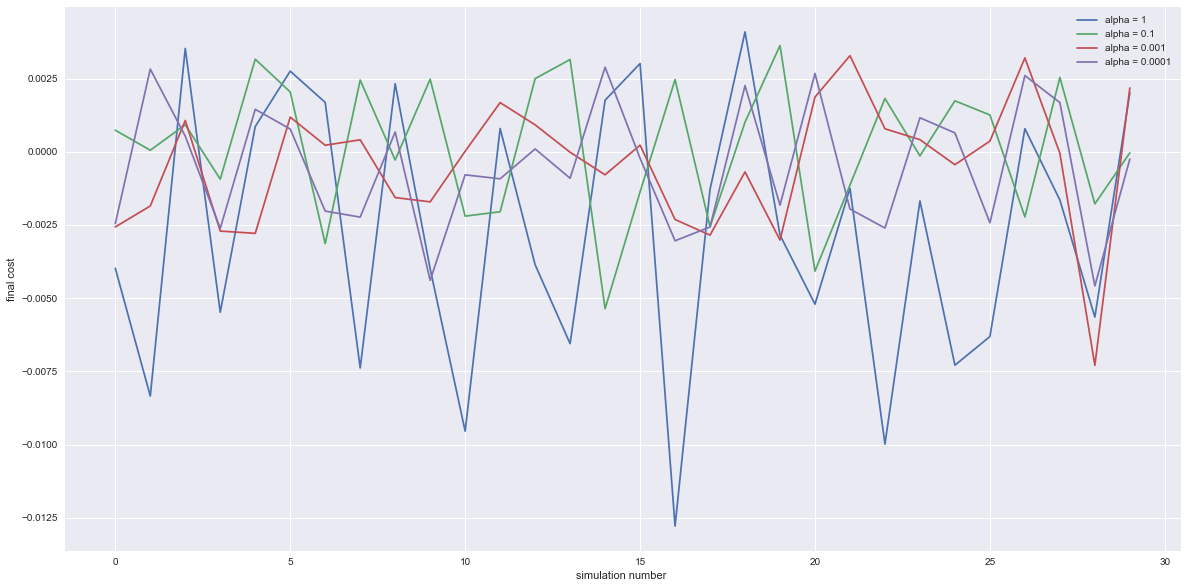

In [188]:
plt.figure(figsize=(20,10))
plt.plot(alpha_costs[0], label='alpha = 1')
plt.plot(alpha_costs[1], label='alpha = 0.1')
plt.plot(alpha_costs[2], label='alpha = 0.001')
plt.plot(alpha_costs[3], label='alpha = 0.0001')
plt.xlabel('simulation number ')
plt.ylabel('final cost')
plt.legend(loc='best')

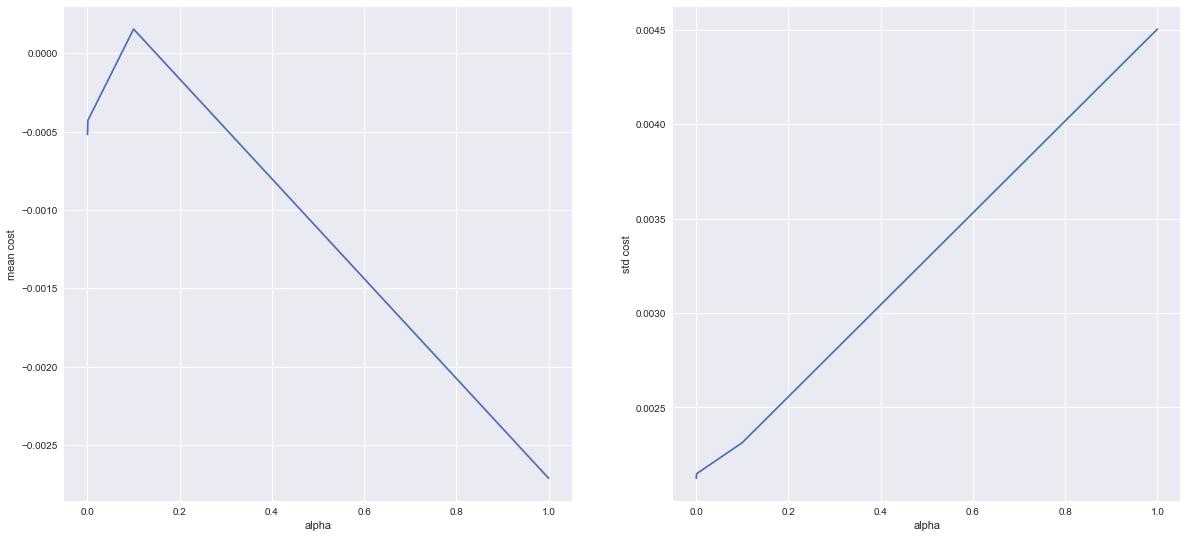

In [176]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.plot(alphas, alpha_costs_means)
plt.xlabel('alpha')
plt.ylabel('mean of the final cost')

plt.subplot(222)
plt.plot(alphas, alpha_cost_sds)
plt.xlabel('alpha')
plt.ylabel('std of the final cost')

### Effect of the choice of learning rate on the performance of the algorithm

With larger learning rates, the standard deviation in the final cost increases as the algorithm takes larger random steps in the parameter space. 

Larger learning rate - could reach an optimum quickly but can not reach level of precision required. WIth smaller learning rates can get stuck 

choice of learning rate on the performance of the algorithm